# Testing Correlation Between Finsler & CA Model (for multi-fidelity)

In [24]:
import numpy as np
from matplotlib import pyplot as plt

from fire_model.ca import FireEnv
from fire_model.finsler import FinslerFireModel

# Core utilities moved to fire_model package
import numpy as np
import matplotlib.pyplot as plt
from fire_model.ca import FireEnv, FireState, CAFireModel
from fire_model.boundary import (
    FireBoundary,
    between_boundaries_mask,
    candidates_from_mask,
    extract_fire_boundary,
    plot_fire_boundary,
)

from fire_model.harmonic import (
    HarmonicStripMap,
    BoundaryMap,
    build_harmonic_strip_map_uniform,
    plot_strip_map,
    sd_to_xy_theta,
    build_boundary_map,
    plot_boundary_correspondence,
)
from fire_model.bo import (
    RetardantDropBayesOpt,
    SearchGridProjector,
    TiedXYFiMatern,
    expected_improvement,
)

def plot_field(field2d, title, cmap=None):
    plt.figure(figsize=(6, 5))
    im = plt.imshow(field2d.T, origin="lower", aspect="equal", cmap=cmap)
    plt.colorbar(im)
    plt.title(title)
    plt.xlabel("x cell")
    plt.ylabel("y cell")
    plt.tight_layout()
    plt.show()

def plot_firestate(state, kind="affected", title=None):
    if kind == "burning":
        field = state.burning[0]
    elif kind == "burned":
        field = state.burned[0]
    elif kind == "affected":
        field = (state.burning[0] > 0.5) | (state.burned[0] > 0.5)
        field = field.astype(float)
    elif kind == "retardant":
        field = state.retardant[0]
    elif kind == "burn_remaining_s":
        field = state.burn_remaining_s[0]
    else:
        raise ValueError("kind must be one of: burning, burned, affected, retardant, burn_remaining_s")
    plot_field(field, title or f"{kind}")


### CA & Finsler Environment Construction

In [20]:
# Grid / domain
nx = ny = 100
domain_km = 5

# Time discretisation (used for indexing time-varying wind and for FireState.t)
dt_s = 1.0

# Fire physics parameters
burn_time_s0 = 15 * 60         # how long a cell stays "burning" after ignition (seconds)
ros_mps = 0.32                 # baseline ROS (m/s)

# Retardant parameters
retardant_half_life_s = 2400.0 # seconds (e.g., 40 minutes)
retardant_k = 1.25             # attenuation strength exp(-k * retardant)

# Spatial maps
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
value = 1.0 + 3.0 * np.exp(-4.0 * ((xs - 0.2) ** 2 + (ys + 0.1) ** 2))

# Constant wind: mild south-westerly
wind=np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = -3
wind[..., 1] = -3

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    wind=wind,
    fuel=fuel,
    value=value,
    dt_s=dt_s,
    burn_time_s0=burn_time_s0,
    retardant_half_life_s=retardant_half_life_s,
    retardant_k=retardant_k,
    ros_mps=ros_mps,
    # wind_coeff is unused by the Finsler model, but can exist in the env
    wind_coeff=0.6,
    diag=True,
)

finsler_model = FinslerFireModel(env, diag=True, k_wind=0.45, w_ref=5.0, k_slope=0.35)
ca_model = CAFireModel(env,seed=42)

### Basic Small Ignition Centre

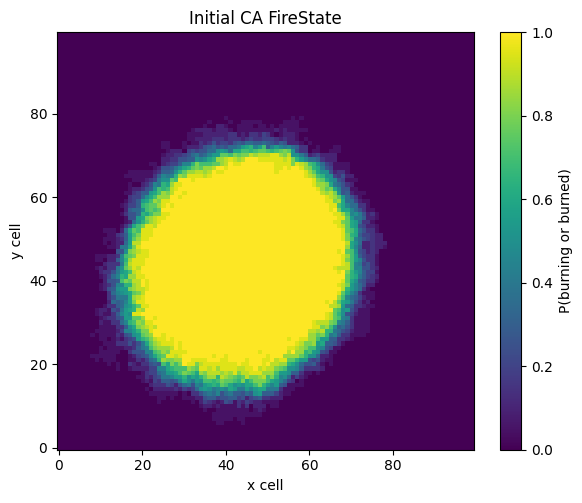

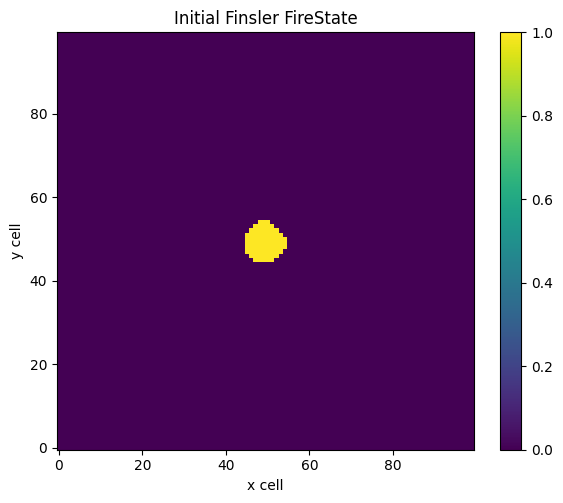

In [29]:
ignition_center = (nx // 2, ny // 2)
ignition_radius_km = 0.1
initial_retardant_drop_time = 300.0  # seconds

init_firestate_ca = ca_model.simulate_from_ignition(
    center=ignition_center,
    radius_km=ignition_radius_km,
    n_sims=20,
    T=initial_retardant_drop_time
)

ca_model.plot_firestate(init_firestate_ca,title="Initial CA FireState")

init_firestate_finsler = finsler_model.simulate_from_ignition(
    center=ignition_center,
    radius_km=ignition_radius_km,
    #n_sims=20,
    T=initial_retardant_drop_time,
)

plot_firestate(init_firestate_finsler,title="Initial Finsler FireState")

In [ ]:
# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = -3
wind[..., 1] = -3

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
    retardant_half_life_s = 500, #small for testing
    retardant_k = 5.0,          #strong for testing
)

model = CAFireModel(default_env, seed=123)
state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

init_firestate = model.simulate_from_ignition(
    T=25, n_sims=5, center=(50, 50), radius_km=0.4,
    ros_mps=2, wind_coeff=0.6, diag=True
)

init_boundary = extract_fire_boundary(
    init_firestate,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    init_firestate,
    init_boundary,
    field="affected",
    title="Fire Boundary at Initialisation"
)

bo = RetardantDropBayesOpt(
    fire_model=model,
    init_firestate=init_firestate,
    evolution_time_s=150.0,
    n_sims=50,
    n_drones=4,
    fire_boundary_probability=0.25,
)

best_theta, best_params, best_obj, (X, y), y_nexts, y_bests = bo.run_bayes_opt(
    n_init=15,
    n_iters=40,
    n_candidates=10000,
    xi=0.01,
    K_grid=500,
    boundary_field="affected",
    verbose=True,
)

print("best objective:", best_obj)
print("best (x,y,phi) per drone:\n", best_params)
